In [13]:
%matplotlib inline
import random
import numpy as np



random.seed(42)
np.random.seed(42)


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import  SAGEConv, GCNConv, GraphConv,GAT,GATConv, GATv2Conv, to_hetero
import matplotlib.pyplot as plt

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42) 

from matgraphdb.mlcore.models import MultiLayerPerceptron, MajorityClassClassifier, WeightedRandomClassifier
from matgraphdb.mlcore.datasets import MaterialGraphDataset
from matgraphdb.mlcore.metrics import ClassificationMetrics,RegressionMetrics


from matgraphdb.mlcore.callbacks import EarlyStopping




# Loading Data

In [14]:
def split_data_on_node_type(data,target_node_type,train_proportion=0.8,test_proportion=0.1, val_proportion=0.1):
    assert train_proportion + test_proportion + val_proportion == 1.0
    for node_type in data.node_types:
        train_mask=torch.zeros(data[node_type].num_nodes,dtype=torch.bool)
        test_mask=torch.zeros(data[node_type].num_nodes,dtype=torch.bool)
        val_mask=torch.zeros(data[node_type].num_nodes,dtype=torch.bool)

        num_nodes_for_type=data[node_type].num_nodes
        if node_type==target_node_type:
            # Determine indices for training, testing, and validation
            indices = torch.randperm(num_nodes_for_type)

            num_train = int(train_proportion * num_nodes_for_type)
            num_val = int(test_proportion * num_nodes_for_type)
            num_test = num_nodes_for_type - num_train - num_val

            train_mask[indices[:num_train]] = True
            val_mask[indices[num_train:num_train + num_val]] = True
            test_mask[indices[num_train + num_val:]] = True
        else:
            train_mask[:num_nodes_for_type]=True

        data[node_type].train_mask=train_mask
        data[node_type].test_mask=test_mask
        data[node_type].val_mask=val_mask
    return data




In [15]:
NODE_TYPE='material'
# 
# TARGET_PROPERTY='energy_above_hull'
# TARGET_PROPERTY='formation_energy_per_atom'
# TARGET_PROPERTY='energy_per_atom'
# TARGET_PROPERTY='band_gap'

# TARGET_PROPERTY='density'
# TARGET_PROPERTY='density_atomic'

TARGET_PROPERTY='k_vrh'
# TARGET_PROPERTY='k_voigt'
# TARGET_PROPERTY='k_reuss'
# TARGET_PROPERTY='g_vrh'
# TARGET_PROPERTY='g_voigt'
# TARGET_PROPERTY='g_reuss'
# TARGET_PROPERTY='sound_velocity_transverse'
# TARGET_PROPERTY='sound_velocity_longitudinal'
# TARGET_PROPERTY='thermal_conductivity_clarke'
# TARGET_PROPERTY='thermal_conductivity_cahill'
# TARGET_PROPERTY='universal_anisotropy'
# TARGET_PROPERTY='homogeneous_poisson'
# TARGET_PROPERTY='debye_temperature'

# TARGET_PROPERTY='crystal_system'
# TARGET_PROPERTY='point_group'
# TARGET_PROPERTY='nelements'
# TARGET_PROPERTY='elements'

# CONNECTION_TYPE='GEOMETRIC_ELECTRIC_CONNECTS'
CONNECTION_TYPE='GEOMETRIC_CONNECTS'
# CONNECTION_TYPE='ELECTRIC_CONNECTS'

# Training params
TRAIN_PROPORTION = 0.8
TEST_PROPORTION = 0.1
VAL_PROPORTION = 0.1


node_filtering={
    'material':{
        'k_vrh':(0,200),
        # 'state':,
        },
    }


node_properties={
'element':
    {
    'properties' :[
            'atomic_number',
            'group',
            'row',
            'atomic_mass'
            ],
    'scale': {
            # 'robust_scale': True,
            # 'standardize': True,
            # 'normalize': True
        }
    },
'material':
        {   
    'properties':[
        # 'composition',
        # 'space_group',
        # 'nelements',
        # 'nsites',
        # 'crystal_system',
        # 'band_gap',
        # 'formation_energy_per_atom',
        # 'energy_per_atom',
        # 'is_stable',
        # 'volume',
        # 'density',
        # 'density_atomic',

        # 'sine_coulomb_matrix',
        # 'element_fraction',
        'element_property',
        # 'xrd_pattern',
        ],
    'scale': {
            # 'robust_scale': True,
            # 'standardize': True,
            # 'normalize': True
        }
        }
    }

edge_properties={
    'weight':
        {
        'properties':[
            'weight'
            ],
        'scale': {
            'robust_scale': True,
            # 'standardize': True,
            # 'normalize': True
        }
    }
    }


if CONNECTION_TYPE=='GEOMETRIC_CONNECTS':
    graph_dataset=MaterialGraphDataset.gc_element_chemenv(
                                            node_properties=node_properties,
                                            node_filtering=node_filtering,
                                            edge_properties=edge_properties,
                                            node_target_property=TARGET_PROPERTY,
                                            edge_target_property=None,

                                            )
elif CONNECTION_TYPE=='ELECTRIC_CONNECTS':
    graph_dataset=MaterialGraphDataset.ec_element_chemenv(
                                            node_properties=node_properties,
                                            node_filtering=node_filtering,
                                            edge_properties=edge_properties,
                                            node_target_property=TARGET_PROPERTY,
                                            edge_target_property=None,
                                            )
elif CONNECTION_TYPE=='GEOMETRIC_ELECTRIC_CONNECTS':
    graph_dataset=MaterialGraphDataset.gec_element_chemenv(
                                            node_properties=node_properties,
                                            node_filtering=node_filtering,
                                            edge_properties=edge_properties,
                                            node_target_property=TARGET_PROPERTY,
                                            edge_target_property=None,
                                            )
    
data=graph_dataset.data
OUT_CHANNELS=data[NODE_TYPE].out_channels

device =  "cuda:0" if torch.cuda.is_available() else torch.device("cpu")
data=split_data_on_node_type(data,
                            target_node_type=NODE_TYPE,
                            train_proportion=TRAIN_PROPORTION,
                            test_proportion=TEST_PROPORTION,
                            val_proportion=VAL_PROPORTION)

print(data)



HeteroData(
  element={
    node_id=[118],
    names=[118],
    x=[118, 4],
    property_names=[4],
    train_mask=[118],
    test_mask=[118],
    val_mask=[118],
  },
  chemenv={
    node_id=[61],
    names=[61],
    num_nodes=61,
    train_mask=[61],
    test_mask=[61],
    val_mask=[61],
  },
  material={
    node_id=[9149],
    names=[9149],
    x=[9149, 132],
    property_names=[1],
    y_label_name='k_vrh',
    out_channels=1,
    y=[9149, 1],
    train_mask=[9149],
    test_mask=[9149],
    val_mask=[9149],
  },
  (chemenv, can_occur, element)={
    edge_index=[2, 3017],
    edge_attr=[3017, 1],
    property_names=[1],
  },
  (element, rev_can_occur, chemenv)={
    edge_index=[2, 3017],
    edge_attr=[3017, 1],
  },
  (chemenv, geometric_connects, chemenv)={
    edge_index=[2, 1499],
    edge_attr=[1499, 1],
    property_names=[1],
  },
  (chemenv, rev_geometric_connects, chemenv)={
    edge_index=[2, 1499],
    edge_attr=[1499, 1],
  },
  (element, geometric_connects, element)=

# Plotting loss function

In [28]:
def plot_loss_curves(train_loss, val_loss, test_loss, best_loss, best_mae_loss, interval=1, **kwargs):
    """
    Plot the train, validation, and test loss curves in a Jupyter notebook,
    including a horizontal line for the best loss.
    
    Parameters:
    - train_loss (list): List of training losses per epoch
    - val_loss (list): List of validation losses per epoch
    - test_loss (list): List of test losses per epoch
    - best_loss (float): The best (lowest) loss achieved
    - interval (int): Interval for x-axis ticks (default: 1)
    
    Returns:
    - fig (matplotlib.figure.Figure): The created figure object
    """
    epochs = range(1, len(train_loss) + 1)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax.plot(epochs, test_loss, 'g-', label='Test Loss')
    
    # Add horizontal dashed line for best loss
    ax.axhline(y=best_loss, color='m', linestyle='--', label=f'Best Loss: {best_loss:.4f}')
    ax.axhline(y=best_mae_loss, color='m', linestyle='--', label=f'Best MAE Loss: {best_mae_loss:.4f}')

    ax.set_title('Training, Validation, and Test Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    
    # Set x-axis ticks at the specified interval
    ax.set_xticks(range(0, len(epochs) + 1, interval))
    
    # Ensure y-axis includes the best loss
    # ax.set_ylim(bottom=min(min(train_loss), min(val_loss), min(test_loss), best_loss) * 0.9)
    ax.set_ylim((0,2000))
    
    ax.grid(True)
    
    return fig

# Training steps

In [22]:
def train_step(model, optimizer, data, loss_fn):
    model.train()
    total_loss = 0
    total_examples = 0

    data = data.to(device)
    optimizer.zero_grad()

    out = model(data)
    mask=data[NODE_TYPE].train_mask
    pred=out[mask]
    ground_truth=data[NODE_TYPE].y[mask]

    loss = loss_fn(pred, ground_truth)

    loss.backward()
    optimizer.step()
    total_loss += float(loss)
    total_examples += pred.numel()

    return total_loss 


def evaluate_step(model, data, optimizer, loss_fn):
    model.eval()
    with torch.no_grad():
        
        losses=[]
        metrics={"val":{},"test":{}}
        data = data.to(device)
        optimizer.zero_grad()

        logits = model(data)
        out_channel=logits.shape[1]
        for key in metrics.keys():
            if out_channel==1:
                metrics[key]['mape']=[]
                metrics[key]['mae']=[]
            else:
                metrics[key]['accuracy']=[]
                metrics[key]['precision']=[]
                metrics[key]['recall']=[]
                metrics[key]['f1']=[]

        for split in ['val_mask', 'test_mask']:
            mask=data[NODE_TYPE][split]
            logits=logits.to(device)
            
            masked_logits=logits[mask]
            ground_truth=data[NODE_TYPE].y[mask]

            loss = loss_fn(masked_logits, ground_truth)

            out_channel=logits.shape[1]
            split_name=split.split('_')[0]
            if out_channel==1:
                mape=RegressionMetrics.mean_absolute_percentage_error(y_pred=masked_logits,y_true=ground_truth)
                mae=RegressionMetrics.mean_absolute_error(y_pred=masked_logits,y_true=ground_truth)
                metrics[split_name]['mape'].append(mape.item())
                metrics[split_name]['mae'].append(mae.item())
            else:
                probabilities = torch.sigmoid(masked_logits)
                # Converting masked_logits from (batch_size, out_channels) to (batch_size,)
                pred=probabilities.argmax(1)

                
                # accuracy=ClassificationMetrics.accuracy(y_pred=pred,y_true=ground_truth)
                # metrics[split_name]['accuracy'].append(accuracy.item()*100)

                cm=ClassificationMetrics.confusion_matrix(y_pred=pred,y_true=ground_truth,num_classes=out_channel)

                weights=cm.sum(dim=1)/cm.sum(dim=1).sum()

                accuracy=ClassificationMetrics.multi_class_accuracy(confusion_matrix=cm)
                avg_accuracy=(weights * accuracy).sum()
                metrics[split_name]['accuracy'].append(avg_accuracy*100)

                precision=ClassificationMetrics.multiclass_precision(confusion_matrix=cm)
                avg_precision= (weights * precision).sum()
                metrics[split_name]['precision'].append(avg_precision*100)

                recall=ClassificationMetrics.multiclass_recall(confusion_matrix=cm)
                avg_recall=(weights * recall).sum()
                metrics[split_name]['recall'].append(avg_recall*100)

                f1=ClassificationMetrics.multiclass_f1_score(confusion_matrix=cm)
                avg_f1=(weights * f1).sum()
                metrics[split_name]['f1'].append(avg_f1*100)

            losses.append(loss.item())

    return losses,metrics

# Training Loop

In [23]:
def train(model, optimizer, data, loss_fn, es=None, n_epochs=3000, eval_interval=10):
    train_losses=[]
    test_losses=[]
    val_losses=[]
    test_mae=[]
    for epoch in range(n_epochs):
        train_loss = train_step(model, optimizer, data, loss_fn=loss_fn)

        if epoch%eval_interval==0:
            losses,metrics = evaluate_step(model, data, optimizer, loss_fn)

            # print(f"Epoch: {epoch:03d},Train Loss: {train_loss:.4f}, Val Loss: {losses[0]:.4f}, Test Loss: {losses[1]:.4f}")

            metrics_str=""
            metrics_str+=f"Epoch: {epoch:03d},Train Loss: {train_loss:.4f}, Test Loss: {losses[1]:.4f}"
            for split,metrics_dict in metrics.items():
                metrics_str+=" | "
                for i,(key,value) in enumerate(metrics_dict.items()):
                    if i==0:
                        metrics_str+=f" {split}-{key}: {value[0]:.2f}"
                    else:
                        metrics_str+=f", {split}-{key}: {value[0]:.2f}"
            print(metrics_str)
            train_losses.append(train_loss)
            test_losses.append(losses[1])
            val_losses.append(losses[0])
            test_mae.append(metrics['test']['mae'][0])

        if es is not None:
            if es(model=model, test_loss=losses[1], mae_loss=metrics['test']['mae'][0]):
                best_loss=losses[1]

                print("Early stopping")
                print('_______________________')
                print(f'Stopping : {epoch - es.counter}')
                print(f'Best loss: {es.best_loss}')
                break

    plot_loss_curves(train_losses, val_losses, test_losses, 
                     es.best_loss, 
                     es.best_mae_loss, 
                     interval=eval_interval)
        
        # if USE_LEARNING_RATE_SCHEDULER:
        #     scheduler.step()

# edge attributes as edgr_attrs

SupervisedHeteroGATModel(
  (embs): ModuleDict(
    (element): Embedding(118, 256)
    (chemenv): Embedding(61, 256)
    (material): Embedding(9149, 256)
  )
  (data_lins): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (conv_layers): GraphModule(
    (_trim): ModuleDict(
      (chemenv__can_occur__element): TrimToLayer()
      (element__rev_can_occur__chemenv): TrimToLayer()
      (chemenv__geometric_connects__chemenv): TrimToLayer()
      (chemenv__rev_geometric_connects__chemenv): TrimToLayer()
      (element__geometric_connects__element): TrimToLayer()
      (element__rev_geometric_connects__element): TrimToLayer()
      (material__has__chemenv): TrimToLayer()
      (chemenv__rev_has__material): TrimToLayer()
      (material__has__element): TrimToLayer()
      (element__rev_has__material): TrimToLayer()
    )
    (convs): ModuleList(
      (0-1): 2 x ModuleDict(
        (chemen

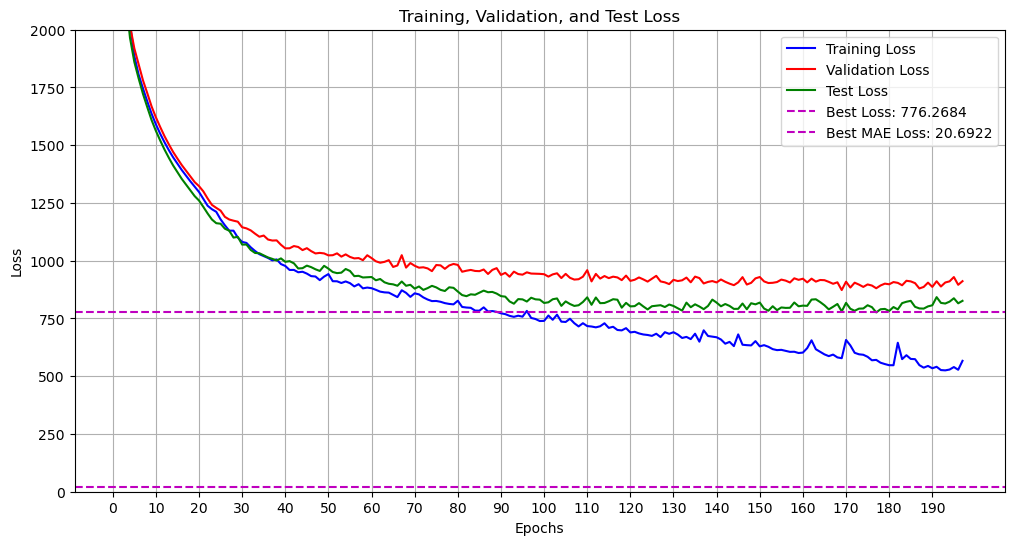

In [29]:
class SupervisedHeteroGATModel(nn.Module):
    def __init__(self, data,
                 embd_dim:int,
                 out_channels:int,
                 heads:int,
                 prediction_node_type:str,
                 num_layers,
                 device='cuda:0',
                 aggr='sum',
                 **kwargs):
        super(SupervisedHeteroGATModel, self).__init__()
        if aggr == ['sum','mean','min','max','mul']:
            raise ValueError("aggr must be one of ['sum','mean','min','max','mul']")

        self.prediction_node_type=prediction_node_type

        self.embs = nn.ModuleDict()
        self.data_lins = nn.ModuleDict()
        for node_type in data.node_types:
            num_nodes = data[node_type].num_nodes
            num_features = data[node_type].num_node_features
            self.embs[node_type]=nn.Embedding(num_nodes,embd_dim,device=device)
            if num_features != 0:
                self.data_lins[node_type]=nn.Linear(num_features, embd_dim,device=device)
        edge_dim=None
        for edge_type in data.edge_types:
            if len(data[edge_type].edge_attr.shape)>0:
                edge_dim=data[edge_type].edge_attr.shape[1]


        
        
        # Initialize and convert GraphSAGE to heterogeneous
        self.conv_layers = GAT(
                            in_channels=embd_dim, 
                            hidden_channels=embd_dim, 
                            num_layers=num_layers,
                            v2=True,
                            act='leaky_relu',
                            act_first=True,
                            add_self_loops=False, 
                            edge_dim=1,
                            heads=heads,
                            **kwargs)
        self.conv_layers = to_hetero(self.conv_layers, metadata=data.metadata(), aggr=aggr)
        self.output_layer = nn.Linear(embd_dim, out_channels)
        self.ln_in=nn.LayerNorm(embd_dim)
        self.ln_f=nn.LayerNorm(embd_dim)

    def forward(self, data):
        x_dict={}

        for node_type, emb_layer in self.embs.items():
            # Handling nodes based on feature availability
            if node_type in self.data_lins:
                out = self.ln_in(self.data_lins[node_type](data[node_type].x) + emb_layer(data[node_type].node_id))
                x_dict[node_type] = self.data_lins[node_type](data[node_type].x)# + emb_layer(data[node_type].node_id)

            else:
                x_dict[node_type] = emb_layer(data[node_type].node_id)


        # x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_weight=data.edge_attr_dict)
        x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_attr=data.edge_attr_dict)

        out=self.ln_f(x_dict[self.prediction_node_type]) + self.data_lins[self.prediction_node_type](data[self.prediction_node_type].x)
        out=self.output_layer(out)
        # out=self.output_layer(x_dict[self.prediction_node_type])
        return out
    

LEARNING_RATE = 0.0003
N_EPCOHS = 3000

# model params
HEADS = 4
NUM_LAYERS = 2
HIDDEN_CHANNELS =256
EVAL_INTERVAL = 10

USE_EARLY_STOPPING=True
EARLY_STOPPING_PATIENCE = 200



model = SupervisedHeteroGATModel(data,
                            embd_dim=HIDDEN_CHANNELS, 
                            out_channels=OUT_CHANNELS,
                            prediction_node_type=NODE_TYPE,
                            num_layers=NUM_LAYERS,
                            heads=HEADS,
                            aggr='sum',
                            device=device)

print(model)
model.to(device)
data=data.to(device)
model(data)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

es = None
if USE_EARLY_STOPPING:
    es = EarlyStopping(patience = EARLY_STOPPING_PATIENCE)


if OUT_CHANNELS==1:
    print("Using MSE Loss")
    loss_fn=nn.MSELoss()
else:
    print("Using Cross Entropy Loss")
    loss_fn=nn.CrossEntropyLoss()

train(model, optimizer, data, loss_fn, es=es, n_epochs=N_EPCOHS, eval_interval=EVAL_INTERVAL)

# No attributes

SupervisedHeteroGATModel(
  (embs): ModuleDict(
    (element): Embedding(118, 256)
    (chemenv): Embedding(61, 256)
    (material): Embedding(9149, 256)
  )
  (data_lins): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (conv_layers): GraphModule(
    (_trim): ModuleDict(
      (chemenv__can_occur__element): TrimToLayer()
      (element__rev_can_occur__chemenv): TrimToLayer()
      (chemenv__geometric_connects__chemenv): TrimToLayer()
      (chemenv__rev_geometric_connects__chemenv): TrimToLayer()
      (element__geometric_connects__element): TrimToLayer()
      (element__rev_geometric_connects__element): TrimToLayer()
      (material__has__chemenv): TrimToLayer()
      (chemenv__rev_has__material): TrimToLayer()
      (material__has__element): TrimToLayer()
      (element__rev_has__material): TrimToLayer()
    )
    (convs): ModuleList(
      (0-1): 2 x ModuleDict(
        (chemen

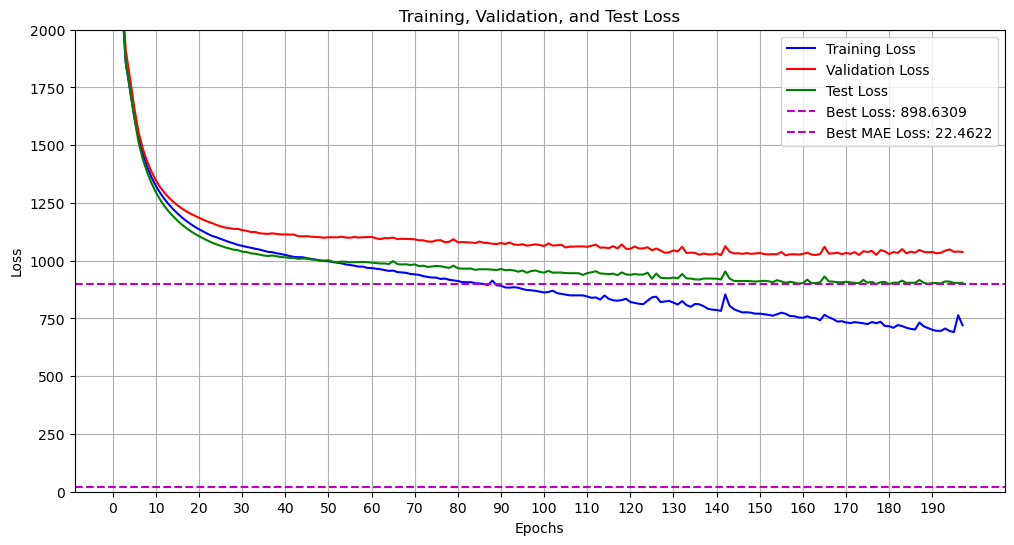

In [30]:
class SupervisedHeteroGATModel(nn.Module):
    def __init__(self, data,
                 embd_dim:int,
                 out_channels:int,
                 heads:int,
                 prediction_node_type:str,
                 num_layers,
                 device='cuda:0',
                 aggr='sum',
                 **kwargs):
        super(SupervisedHeteroGATModel, self).__init__()
        if aggr == ['sum','mean','min','max','mul']:
            raise ValueError("aggr must be one of ['sum','mean','min','max','mul']")

        self.prediction_node_type=prediction_node_type

        self.embs = nn.ModuleDict()
        self.data_lins = nn.ModuleDict()
        for node_type in data.node_types:
            num_nodes = data[node_type].num_nodes
            num_features = data[node_type].num_node_features
            self.embs[node_type]=nn.Embedding(num_nodes,embd_dim,device=device)
            if num_features != 0:
                self.data_lins[node_type]=nn.Linear(num_features, embd_dim,device=device)
        edge_dim=None
        for edge_type in data.edge_types:
            if len(data[edge_type].edge_attr.shape)>0:
                edge_dim=data[edge_type].edge_attr.shape[1]


        
        
        # Initialize and convert GraphSAGE to heterogeneous
        self.conv_layers = GAT(
                            in_channels=embd_dim, 
                            hidden_channels=embd_dim, 
                            num_layers=num_layers,
                            v2=True,
                            act='leaky_relu',
                            act_first=True,
                            add_self_loops=False, 
                            edge_dim=None,
                            heads=heads,
                            **kwargs)
        self.conv_layers = to_hetero(self.conv_layers, metadata=data.metadata(), aggr=aggr)
        self.output_layer = nn.Linear(embd_dim, out_channels)
        self.ln_in=nn.LayerNorm(embd_dim)
        self.ln_f=nn.LayerNorm(embd_dim)

    def forward(self, data):
        x_dict={}

        for node_type, emb_layer in self.embs.items():
            # Handling nodes based on feature availability
            if node_type in self.data_lins:
                out = self.ln_in(self.data_lins[node_type](data[node_type].x) + emb_layer(data[node_type].node_id))
                x_dict[node_type] = self.data_lins[node_type](data[node_type].x)# + emb_layer(data[node_type].node_id)

            else:
                x_dict[node_type] = emb_layer(data[node_type].node_id)


        x_dict=self.conv_layers(x_dict, data.edge_index_dict)


        out=self.ln_f(x_dict[self.prediction_node_type]) + self.data_lins[self.prediction_node_type](data[self.prediction_node_type].x)
        out=self.output_layer(out)
        # out=self.output_layer(x_dict[self.prediction_node_type])
        return out
    

LEARNING_RATE = 0.0003
N_EPCOHS = 3000

# model params
HEADS = 4
NUM_LAYERS = 2
HIDDEN_CHANNELS =256
EVAL_INTERVAL = 10

USE_EARLY_STOPPING=True
EARLY_STOPPING_PATIENCE = 200



model = SupervisedHeteroGATModel(data,
                            embd_dim=HIDDEN_CHANNELS, 
                            out_channels=OUT_CHANNELS,
                            prediction_node_type=NODE_TYPE,
                            num_layers=NUM_LAYERS,
                            heads=HEADS,
                            aggr='sum',
                            device=device)

print(model)
model.to(device)
data=data.to(device)
model(data)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

es = None
if USE_EARLY_STOPPING:
    es = EarlyStopping(patience = EARLY_STOPPING_PATIENCE)


if OUT_CHANNELS==1:
    print("Using MSE Loss")
    loss_fn=nn.MSELoss()
else:
    print("Using Cross Entropy Loss")
    loss_fn=nn.CrossEntropyLoss()

train(model, optimizer, data, loss_fn, es=es, n_epochs=N_EPCOHS, eval_interval=EVAL_INTERVAL)

# Different mean aggregation method

SupervisedHeteroGATModel(
  (embs): ModuleDict(
    (element): Embedding(118, 256)
    (chemenv): Embedding(61, 256)
    (material): Embedding(9149, 256)
  )
  (data_lins): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (conv_layers): GraphModule(
    (_trim): ModuleDict(
      (chemenv__can_occur__element): TrimToLayer()
      (element__rev_can_occur__chemenv): TrimToLayer()
      (chemenv__geometric_connects__chemenv): TrimToLayer()
      (chemenv__rev_geometric_connects__chemenv): TrimToLayer()
      (element__geometric_connects__element): TrimToLayer()
      (element__rev_geometric_connects__element): TrimToLayer()
      (material__has__chemenv): TrimToLayer()
      (chemenv__rev_has__material): TrimToLayer()
      (material__has__element): TrimToLayer()
      (element__rev_has__material): TrimToLayer()
    )
    (convs): ModuleList(
      (0-1): 2 x ModuleDict(
        (chemen

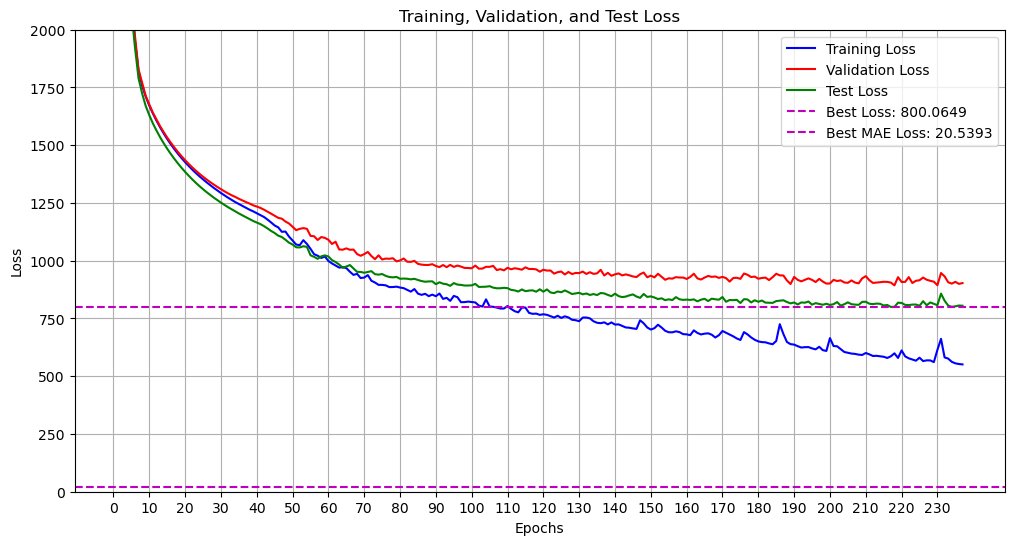

In [31]:
class SupervisedHeteroGATModel(nn.Module):
    def __init__(self, data,
                 embd_dim:int,
                 out_channels:int,
                 heads:int,
                 prediction_node_type:str,
                 num_layers,
                 device='cuda:0',
                 aggr='sum',
                 **kwargs):
        super(SupervisedHeteroGATModel, self).__init__()
        if aggr == ['sum','mean','min','max','mul']:
            raise ValueError("aggr must be one of ['sum','mean','min','max','mul']")

        self.prediction_node_type=prediction_node_type

        self.embs = nn.ModuleDict()
        self.data_lins = nn.ModuleDict()
        for node_type in data.node_types:
            num_nodes = data[node_type].num_nodes
            num_features = data[node_type].num_node_features
            self.embs[node_type]=nn.Embedding(num_nodes,embd_dim,device=device)
            if num_features != 0:
                self.data_lins[node_type]=nn.Linear(num_features, embd_dim,device=device)
        edge_dim=None
        for edge_type in data.edge_types:
            if len(data[edge_type].edge_attr.shape)>0:
                edge_dim=data[edge_type].edge_attr.shape[1]


        
        
        # Initialize and convert GraphSAGE to heterogeneous
        self.conv_layers = GAT(
                            in_channels=embd_dim, 
                            hidden_channels=embd_dim, 
                            num_layers=num_layers,
                            v2=True,
                            act='leaky_relu',
                            act_first=True,
                            add_self_loops=False, 
                            edge_dim=1,
                            heads=heads,
                            **kwargs)
        self.conv_layers = to_hetero(self.conv_layers, metadata=data.metadata(), aggr=aggr)
        self.output_layer = nn.Linear(embd_dim, out_channels)
        self.ln_in=nn.LayerNorm(embd_dim)
        self.ln_f=nn.LayerNorm(embd_dim)

    def forward(self, data):
        x_dict={}

        for node_type, emb_layer in self.embs.items():
            # Handling nodes based on feature availability
            if node_type in self.data_lins:
                out = self.ln_in(self.data_lins[node_type](data[node_type].x) + emb_layer(data[node_type].node_id))
                x_dict[node_type] = self.data_lins[node_type](data[node_type].x)# + emb_layer(data[node_type].node_id)

            else:
                x_dict[node_type] = emb_layer(data[node_type].node_id)


        # x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_weight=data.edge_attr_dict)
        x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_attr=data.edge_attr_dict)

        out=self.ln_f(x_dict[self.prediction_node_type]) + self.data_lins[self.prediction_node_type](data[self.prediction_node_type].x)
        out=self.output_layer(out)
        # out=self.output_layer(x_dict[self.prediction_node_type])
        return out
    

LEARNING_RATE = 0.0003
N_EPCOHS = 3000

# model params
HEADS = 4
NUM_LAYERS = 2
HIDDEN_CHANNELS =256
EVAL_INTERVAL = 10

USE_EARLY_STOPPING=True
EARLY_STOPPING_PATIENCE = 200



model = SupervisedHeteroGATModel(data,
                            embd_dim=HIDDEN_CHANNELS, 
                            out_channels=OUT_CHANNELS,
                            prediction_node_type=NODE_TYPE,
                            num_layers=NUM_LAYERS,
                            heads=HEADS,
                            aggr='mean',
                            device=device)

print(model)
model.to(device)
data=data.to(device)
model(data)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

es = None
if USE_EARLY_STOPPING:
    es = EarlyStopping(patience = EARLY_STOPPING_PATIENCE)


if OUT_CHANNELS==1:
    print("Using MSE Loss")
    loss_fn=nn.MSELoss()
else:
    print("Using Cross Entropy Loss")
    loss_fn=nn.CrossEntropyLoss()

train(model, optimizer, data, loss_fn, es=es, n_epochs=N_EPCOHS, eval_interval=EVAL_INTERVAL)

# Using serpate linear layers for skip connections

SupervisedHeteroGATModel(
  (embs): ModuleDict(
    (element): Embedding(118, 256)
    (chemenv): Embedding(61, 256)
    (material): Embedding(9149, 256)
  )
  (data_lins): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (data_lins_2): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (conv_layers): GraphModule(
    (_trim): ModuleDict(
      (chemenv__can_occur__element): TrimToLayer()
      (element__rev_can_occur__chemenv): TrimToLayer()
      (chemenv__geometric_connects__chemenv): TrimToLayer()
      (chemenv__rev_geometric_connects__chemenv): TrimToLayer()
      (element__geometric_connects__element): TrimToLayer()
      (element__rev_geometric_connects__element): TrimToLayer()
      (material__has__chemenv): TrimToLayer()
      (chemenv__rev_has__material): TrimToLayer()
   

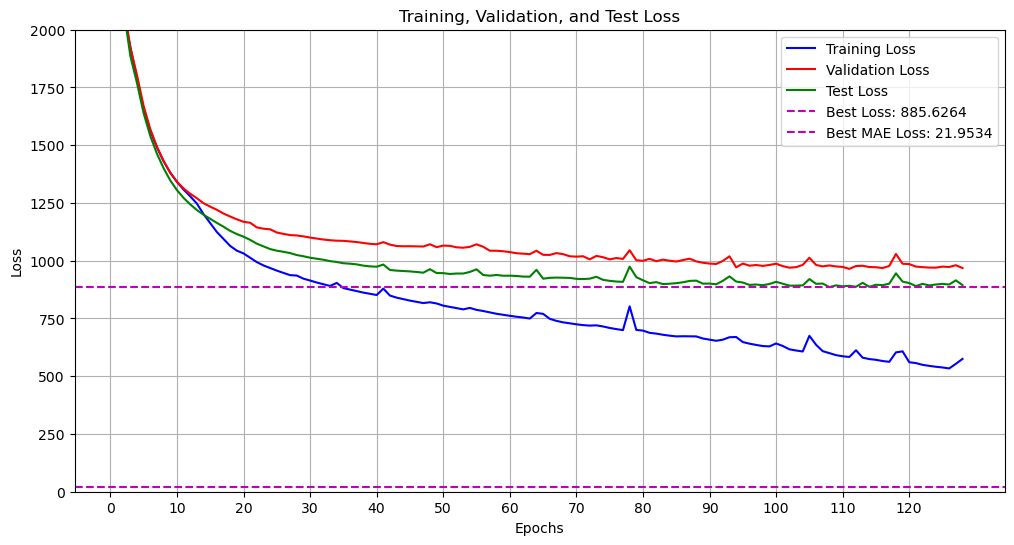

In [34]:
class SupervisedHeteroGATModel(nn.Module):
    def __init__(self, data,
                 embd_dim:int,
                 out_channels:int,
                 heads:int,
                 prediction_node_type:str,
                 num_layers,
                 device='cuda:0',
                 aggr='sum',
                 **kwargs):
        super(SupervisedHeteroGATModel, self).__init__()
        if aggr == ['sum','mean','min','max','mul']:
            raise ValueError("aggr must be one of ['sum','mean','min','max','mul']")

        self.prediction_node_type=prediction_node_type

        self.embs = nn.ModuleDict()
        self.data_lins = nn.ModuleDict()
        self.data_lins_2 = nn.ModuleDict()
        for node_type in data.node_types:
            num_nodes = data[node_type].num_nodes
            num_features = data[node_type].num_node_features
            self.embs[node_type]=nn.Embedding(num_nodes,embd_dim,device=device)
            if num_features != 0:
                self.data_lins[node_type]=nn.Linear(num_features, embd_dim,device=device)

                self.data_lins_2[node_type]=nn.Linear(num_features, embd_dim,device=device)
        edge_dim=None
        for edge_type in data.edge_types:
            if len(data[edge_type].edge_attr.shape)>0:
                edge_dim=data[edge_type].edge_attr.shape[1]


        
        
        # Initialize and convert GraphSAGE to heterogeneous
        self.conv_layers = GAT(
                            in_channels=embd_dim, 
                            hidden_channels=embd_dim, 
                            num_layers=num_layers,
                            v2=True,
                            act='leaky_relu',
                            act_first=True,
                            add_self_loops=False, 
                            edge_dim=1,
                            heads=heads,
                            **kwargs)
        self.conv_layers = to_hetero(self.conv_layers, metadata=data.metadata(), aggr=aggr)
        self.output_layer = nn.Linear(embd_dim, out_channels)
        self.ln_in=nn.LayerNorm(embd_dim)
        self.ln_f=nn.LayerNorm(embd_dim)

    def forward(self, data):
        x_dict={}

        for node_type, emb_layer in self.embs.items():
            # Handling nodes based on feature availability
            if node_type in self.data_lins:
                out = self.ln_in(self.data_lins[node_type](data[node_type].x) + emb_layer(data[node_type].node_id))
                # x_dict[node_type] = self.data_lins[node_type](data[node_type].x)# + emb_layer(data[node_type].node_id)

                x_dict[node_type] = out

            else:
                x_dict[node_type] = emb_layer(data[node_type].node_id)


        # x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_weight=data.edge_attr_dict)
        x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_attr=data.edge_attr_dict)

        out=self.ln_f(x_dict[self.prediction_node_type]) + self.data_lins_2[self.prediction_node_type](data[self.prediction_node_type].x)
        out=self.output_layer(out)
        # out=self.output_layer(x_dict[self.prediction_node_type])
        return out
    

LEARNING_RATE = 0.0003
N_EPCOHS = 3000

# model params
HEADS = 4
NUM_LAYERS = 2
HIDDEN_CHANNELS =256
EVAL_INTERVAL = 10

USE_EARLY_STOPPING=True
EARLY_STOPPING_PATIENCE = 200



model = SupervisedHeteroGATModel(data,
                            embd_dim=HIDDEN_CHANNELS, 
                            out_channels=OUT_CHANNELS,
                            prediction_node_type=NODE_TYPE,
                            num_layers=NUM_LAYERS,
                            heads=HEADS,
                            aggr='mean',
                            device=device)

print(model)
model.to(device)
data=data.to(device)
model(data)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

es = None
if USE_EARLY_STOPPING:
    es = EarlyStopping(patience = EARLY_STOPPING_PATIENCE)


if OUT_CHANNELS==1:
    print("Using MSE Loss")
    loss_fn=nn.MSELoss()
else:
    print("Using Cross Entropy Loss")
    loss_fn=nn.CrossEntropyLoss()

train(model, optimizer, data, loss_fn, es=es, n_epochs=N_EPCOHS, eval_interval=EVAL_INTERVAL)

# Testing no embedding layer

SupervisedHeteroGATModel(
  (embs): ModuleDict(
    (element): Embedding(118, 256)
    (chemenv): Embedding(61, 256)
    (material): Embedding(9149, 256)
  )
  (data_lins): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (data_lins_2): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (conv_layers): GraphModule(
    (_trim): ModuleDict(
      (chemenv__can_occur__element): TrimToLayer()
      (element__rev_can_occur__chemenv): TrimToLayer()
      (chemenv__geometric_connects__chemenv): TrimToLayer()
      (chemenv__rev_geometric_connects__chemenv): TrimToLayer()
      (element__geometric_connects__element): TrimToLayer()
      (element__rev_geometric_connects__element): TrimToLayer()
      (material__has__chemenv): TrimToLayer()
      (chemenv__rev_has__material): TrimToLayer()
   

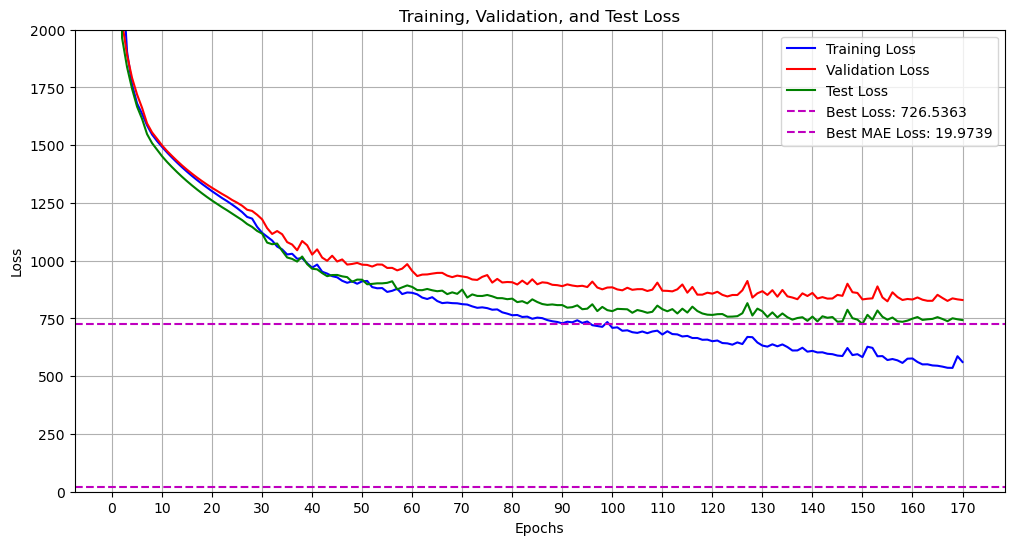

In [33]:
class SupervisedHeteroGATModel(nn.Module):
    def __init__(self, data,
                 embd_dim:int,
                 out_channels:int,
                 heads:int,
                 prediction_node_type:str,
                 num_layers,
                 device='cuda:0',
                 aggr='sum',
                 **kwargs):
        super(SupervisedHeteroGATModel, self).__init__()
        if aggr == ['sum','mean','min','max','mul']:
            raise ValueError("aggr must be one of ['sum','mean','min','max','mul']")

        self.prediction_node_type=prediction_node_type

        self.embs = nn.ModuleDict()
        self.data_lins = nn.ModuleDict()
        self.data_lins_2 = nn.ModuleDict()
        for node_type in data.node_types:
            num_nodes = data[node_type].num_nodes
            num_features = data[node_type].num_node_features
            self.embs[node_type]=nn.Embedding(num_nodes,embd_dim,device=device)
            if num_features != 0:
                self.data_lins[node_type]=nn.Linear(num_features, embd_dim,device=device)

                self.data_lins_2[node_type]=nn.Linear(num_features, embd_dim,device=device)
        edge_dim=None
        for edge_type in data.edge_types:
            if len(data[edge_type].edge_attr.shape)>0:
                edge_dim=data[edge_type].edge_attr.shape[1]

        # Initialize and convert GraphSAGE to heterogeneous
        self.conv_layers = GAT(
                            in_channels=embd_dim, 
                            hidden_channels=embd_dim, 
                            num_layers=num_layers,
                            v2=True,
                            act='leaky_relu',
                            act_first=True,
                            add_self_loops=False, 
                            edge_dim=1,
                            heads=heads,
                            **kwargs)
        self.conv_layers = to_hetero(self.conv_layers, metadata=data.metadata(), aggr=aggr)
        self.output_layer = nn.Linear(embd_dim, out_channels)
        self.ln_in=nn.LayerNorm(embd_dim)
        self.ln_f=nn.LayerNorm(embd_dim)

    def forward(self, data):
        x_dict={}

        for node_type, emb_layer in self.embs.items():
            # Handling nodes based on feature availability
            if node_type in self.data_lins:
                x_dict[node_type] = out# + emb_layer(data[node_type].node_id)

            else:
                x_dict[node_type] = emb_layer(data[node_type].node_id)


        x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_attr=data.edge_attr_dict)

        out=self.ln_f(x_dict[self.prediction_node_type]) + self.data_lins_2[self.prediction_node_type](data[self.prediction_node_type].x)
        out=self.output_layer(out)
        return out
    

LEARNING_RATE = 0.0003
N_EPCOHS = 3000

# model params
HEADS = 4
NUM_LAYERS = 2
HIDDEN_CHANNELS =256
EVAL_INTERVAL = 10

USE_EARLY_STOPPING=True
EARLY_STOPPING_PATIENCE = 200



model = SupervisedHeteroGATModel(data,
                            embd_dim=HIDDEN_CHANNELS, 
                            out_channels=OUT_CHANNELS,
                            prediction_node_type=NODE_TYPE,
                            num_layers=NUM_LAYERS,
                            heads=HEADS,
                            aggr='mean',
                            device=device)

print(model)
model.to(device)
data=data.to(device)
model(data)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

es = None
if USE_EARLY_STOPPING:
    es = EarlyStopping(patience = EARLY_STOPPING_PATIENCE)


if OUT_CHANNELS==1:
    print("Using MSE Loss")
    loss_fn=nn.MSELoss()
else:
    print("Using Cross Entropy Loss")
    loss_fn=nn.CrossEntropyLoss()

train(model, optimizer, data, loss_fn, es=es, n_epochs=N_EPCOHS, eval_interval=EVAL_INTERVAL)

# Testing no linear intitial layer transformation layer

SupervisedHeteroGATModel(
  (embs): ModuleDict(
    (element): Embedding(118, 256)
    (chemenv): Embedding(61, 256)
    (material): Embedding(9149, 256)
  )
  (data_lins): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (data_lins_2): ModuleDict(
    (element): Linear(in_features=4, out_features=256, bias=True)
    (material): Linear(in_features=132, out_features=256, bias=True)
  )
  (conv_layers): GraphModule(
    (_trim): ModuleDict(
      (chemenv__can_occur__element): TrimToLayer()
      (element__rev_can_occur__chemenv): TrimToLayer()
      (chemenv__geometric_connects__chemenv): TrimToLayer()
      (chemenv__rev_geometric_connects__chemenv): TrimToLayer()
      (element__geometric_connects__element): TrimToLayer()
      (element__rev_geometric_connects__element): TrimToLayer()
      (material__has__chemenv): TrimToLayer()
      (chemenv__rev_has__material): TrimToLayer()
   

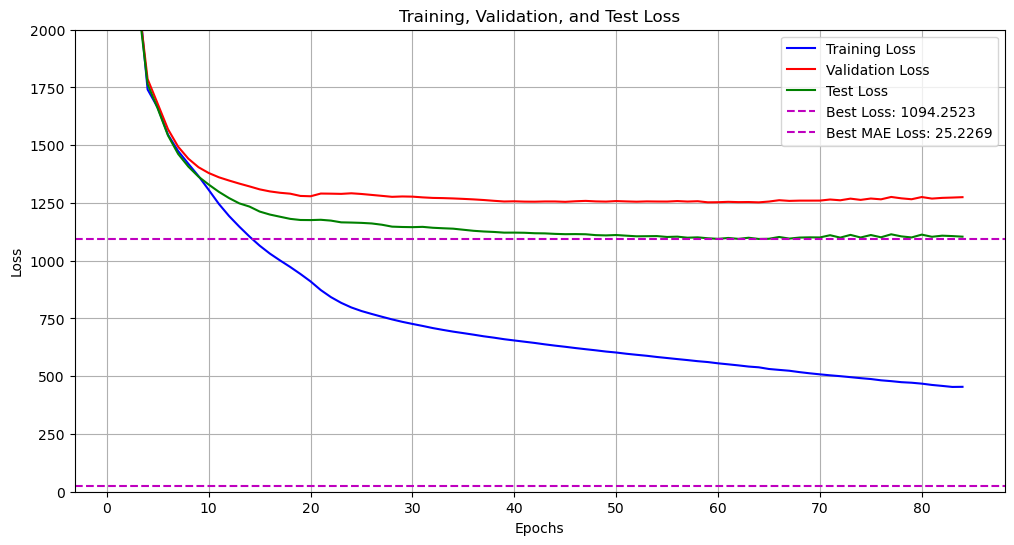

In [35]:
class SupervisedHeteroGATModel(nn.Module):
    def __init__(self, data,
                 embd_dim:int,
                 out_channels:int,
                 heads:int,
                 prediction_node_type:str,
                 num_layers,
                 device='cuda:0',
                 aggr='sum',
                 **kwargs):
        super(SupervisedHeteroGATModel, self).__init__()
        if aggr == ['sum','mean','min','max','mul']:
            raise ValueError("aggr must be one of ['sum','mean','min','max','mul']")

        self.prediction_node_type=prediction_node_type

        self.embs = nn.ModuleDict()
        self.data_lins = nn.ModuleDict()
        self.data_lins_2 = nn.ModuleDict()
        for node_type in data.node_types:
            num_nodes = data[node_type].num_nodes
            num_features = data[node_type].num_node_features
            self.embs[node_type]=nn.Embedding(num_nodes,embd_dim,device=device)
            if num_features != 0:
                self.data_lins[node_type]=nn.Linear(num_features, embd_dim,device=device)

                self.data_lins_2[node_type]=nn.Linear(num_features, embd_dim,device=device)
        edge_dim=None
        for edge_type in data.edge_types:
            if len(data[edge_type].edge_attr.shape)>0:
                edge_dim=data[edge_type].edge_attr.shape[1]


        
        
        # Initialize and convert GraphSAGE to heterogeneous
        self.conv_layers = GAT(
                            in_channels=embd_dim, 
                            hidden_channels=embd_dim, 
                            num_layers=num_layers,
                            v2=True,
                            act='leaky_relu',
                            act_first=True,
                            add_self_loops=False, 
                            edge_dim=1,
                            heads=heads,
                            **kwargs)
        self.conv_layers = to_hetero(self.conv_layers, metadata=data.metadata(), aggr=aggr)
        self.output_layer = nn.Linear(embd_dim, out_channels)
        self.ln_in=nn.LayerNorm(embd_dim)
        self.ln_f=nn.LayerNorm(embd_dim)

    def forward(self, data):
        x_dict={}

        for node_type, emb_layer in self.embs.items():
            # Handling nodes based on feature availability
            if node_type in self.data_lins:
                # print(node_type)
                # out = self.ln_in(self.data_lins[node_type](data[node_type].x) + emb_layer(data[node_type].node_id))
                x_dict[node_type] = emb_layer(data[node_type].node_id)

            else:
                x_dict[node_type] = emb_layer(data[node_type].node_id)


        # x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_weight=data.edge_attr_dict)
        x_dict=self.conv_layers(x_dict, data.edge_index_dict, edge_attr=data.edge_attr_dict)

        out=self.ln_f(x_dict[self.prediction_node_type]) + self.data_lins_2[self.prediction_node_type](data[self.prediction_node_type].x)
        out=self.output_layer(out)
        # out=self.output_layer(x_dict[self.prediction_node_type])
        return out
    


    LEARNING_RATE = 0.0003
N_EPCOHS = 3000

# model params
HEADS = 4
NUM_LAYERS = 2
HIDDEN_CHANNELS =256
EVAL_INTERVAL = 10

USE_EARLY_STOPPING=True
EARLY_STOPPING_PATIENCE = 200



model = SupervisedHeteroGATModel(data,
                            embd_dim=HIDDEN_CHANNELS, 
                            out_channels=OUT_CHANNELS,
                            prediction_node_type=NODE_TYPE,
                            num_layers=NUM_LAYERS,
                            heads=HEADS,
                            aggr='mean',
                            device=device)

print(model)
model.to(device)
data=data.to(device)
model(data)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

es = None
if USE_EARLY_STOPPING:
    es = EarlyStopping(patience = EARLY_STOPPING_PATIENCE)


if OUT_CHANNELS==1:
    print("Using MSE Loss")
    loss_fn=nn.MSELoss()
else:
    print("Using Cross Entropy Loss")
    loss_fn=nn.CrossEntropyLoss()

train(model, optimizer, data, loss_fn, es=es, n_epochs=N_EPCOHS, eval_interval=EVAL_INTERVAL)